In [62]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras import callbacks
from tensorflow.keras.utils import plot_model
from keras.preprocessing.image import load_img

import zipfile
import shutil
import os

## 데이터 준비하기

zip 파일 압축 해제

In [2]:
zip_files = ['test1', 'train']

for zip_file in zip_files:
    with zipfile.ZipFile("/aiffel/aiffel/DLthon/data/{}.zip".format(zip_file), "r") as z:
        z.extractall(".")
        print("{} unzipped".format(zip_file))

test1 unzipped
train unzipped


압축 해제된 파일들을 각각 train data는 강아지와 고양이 사진을 나누어서 working/train/cats, working/train/dogs 폴더로 나누고, test data는 working/test/test에 위치

In [3]:
os.makedirs('/aiffel/aiffel/DLthon/working/train/cats')
os.makedirs('/aiffel/aiffel/DLthon/working/train//dogs')

for root, subdirs, files in os.walk('/aiffel/aiffel/DLthon/train'):
    for f in files:
        if 'cat' in f:
            file_to_move = os.path.join(root, f)
            shutil.move(file_to_move, '/aiffel/aiffel/DLthon/working/train/cats')
        elif 'dog' in f:
            file_to_move = os.path.join(root, f)
            shutil.move(file_to_move, '/aiffel/aiffel/DLthon/working/train//dogs')

In [4]:
os.makedirs('/aiffel/aiffel/DLthon/working/test/test')
for root, subdirs, files in os.walk('/aiffel/aiffel/DLthon/test1'):
    for f in files:
        file_to_move = os.path.join(root, f)
        shutil.move(file_to_move, '/aiffel/aiffel/DLthon/working/test/test')

In [7]:
TRAIN_DIR_PATH = '/aiffel/aiffel/DLthon/working/train'
TEST_DIR_PATH = '/aiffel/aiffel/DLthon/working/test/test'

cat_file_names = os.listdir(TRAIN_DIR_PATH + '/cats')
dog_file_names = os.listdir(TRAIN_DIR_PATH + '/dogs')
test_file_names = os.listdir(TEST_DIR_PATH)

print('There are {} number of images in cats directory.'.format(len(cat_file_names)))
print('There are {} number of images in dogs directory.'.format(len(dog_file_names)))
print('There are {} number of images in test directory.'.format(len(test_file_names)))

There are 12500 number of images in cats directory.
There are 12500 number of images in dogs directory.
There are 12500 number of images in test directory.


Image Data Generator로 데이터 전처리, 준비하기

In [11]:
IMG_SIZE = 224
BATCH_SIZE = 32

In [12]:
train_data_gen = ImageDataGenerator(rescale = 1./255,
                                    validation_split = 0.2)

train_gen = train_data_gen.flow_from_directory(TRAIN_DIR_PATH,
                                              target_size=(IMG_SIZE, IMG_SIZE),
                                              batch_size=BATCH_SIZE,
                                              class_mode='binary',
                                              subset='training')
validation_gen = train_data_gen.flow_from_directory(TRAIN_DIR_PATH,
                                                   target_size=(IMG_SIZE, IMG_SIZE),
                                                  batch_size=BATCH_SIZE,
                                                  class_mode='binary',
                                                  subset='validation')

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [13]:
print(train_gen[0][0].shape)
print(validation_gen[0][0].shape)

(32, 224, 224, 3)
(32, 224, 224, 3)


이미지 확인하기

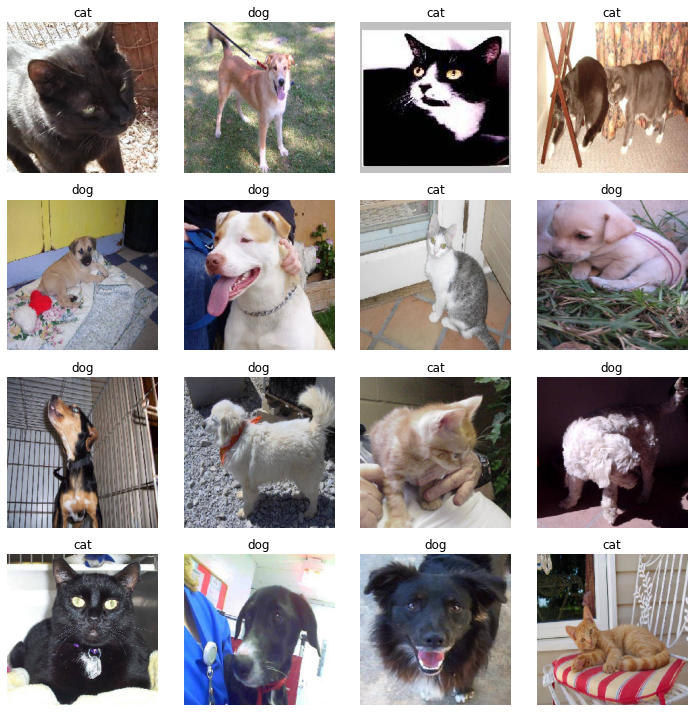

In [16]:
fig, axes = plt.subplots(4, 4, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
    img, label = train_gen.next()
    ax.imshow(img[0])
    ax.set_axis_off()
    if label[0] == 0:
        title = 'cat'
    else:
        title = 'dog'
    ax.set_title(title)
    
plt.tight_layout()
plt.show()

## Vanila CNN을 통해 베이스라인 잡기

In [18]:
model = Sequential()
model.add(Conv2D(32, (3,3), input_shape=(IMG_SIZE, IMG_SIZE, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
             metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 222, 222, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 109, 109, 64)      256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)       

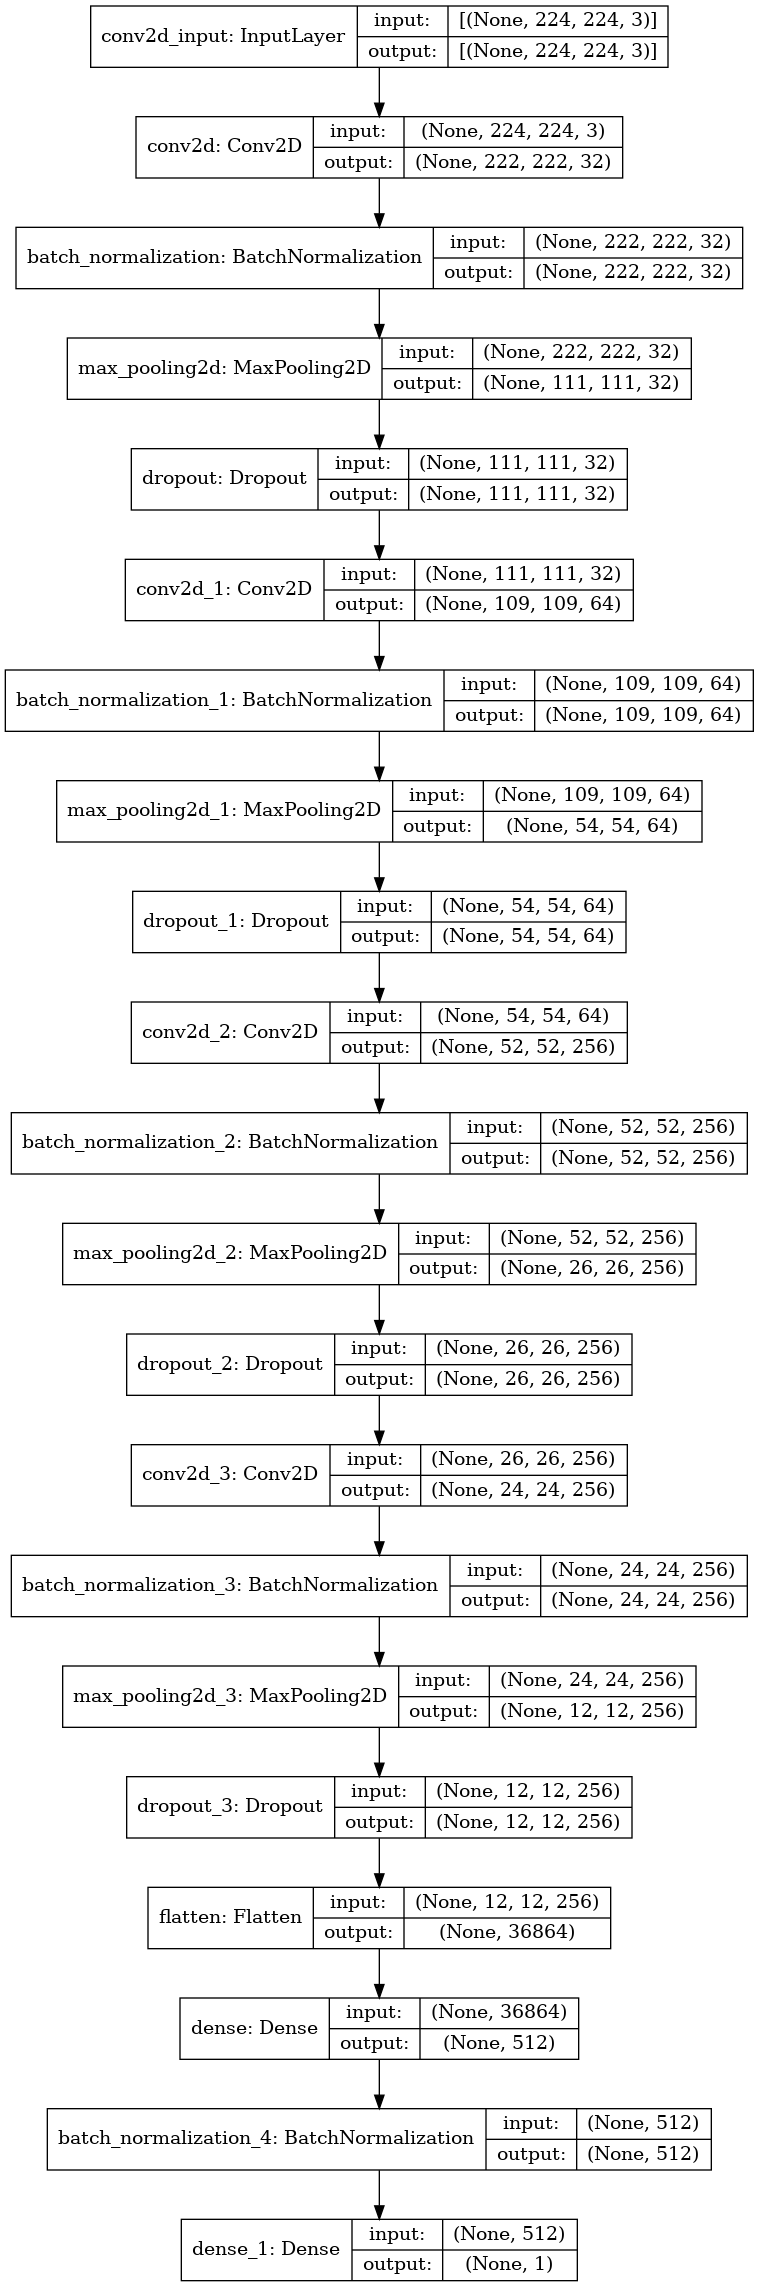

In [20]:
plot_model(model, show_shapes = True, dpi)

In [21]:
cnn_history = model.fit(train_gen,
                       epochs = 10,
                       validation_data = validation_gen)

Epoch 1/10
625/625 [==============================] - 128s 130ms/step - loss: 0.6036 - accuracy: 0.7028 - val_loss: 0.5874 - val_accuracy: 0.7114
Epoch 2/10
625/625 [==============================] - 80s 128ms/step - loss: 0.4278 - accuracy: 0.8013 - val_loss: 0.5723 - val_accuracy: 0.7752
Epoch 3/10
625/625 [==============================] - 79s 127ms/step - loss: 0.3314 - accuracy: 0.8559 - val_loss: 0.9376 - val_accuracy: 0.6558
Epoch 4/10
625/625 [==============================] - 80s 128ms/step - loss: 0.2526 - accuracy: 0.8928 - val_loss: 0.3369 - val_accuracy: 0.8536
Epoch 5/10
625/625 [==============================] - 79s 126ms/step - loss: 0.2002 - accuracy: 0.9196 - val_loss: 0.3252 - val_accuracy: 0.8618
Epoch 6/10
625/625 [==============================] - 80s 128ms/step - loss: 0.1590 - accuracy: 0.9380 - val_loss: 0.3898 - val_accuracy: 0.8514
Epoch 7/10
625/625 [==============================] - 80s 128ms/step - loss: 0.1217 - accuracy: 0.9539 - val_loss: 0.2941 - val_a

In [29]:
def plot_show(history):
    fig, ax = plt.subplots(1, 2, figsize= (10, 5))
    
    Epochs =range(len(history.history['loss']))
    
    sns.lineplot(x = Epochs, y = history.history['val_loss'], label='validation loss', ax=ax[0])
    sns.lineplot(x = Epochs, y = history.history['loss'], label = 'training loss', ax=ax[0])
    ax[0].set_title('loss')
    
    sns.lineplot(x = Epochs, y = history.history['val_accuracy'], label='validation accuracy', ax=ax[1])
    sns.lineplot(x = Epochs, y = history.history['accuracy'], label='training accuracy', ax=ax[1])
    ax[1].set_title('accuracy')
    
    plt.legend()
    plt.show()

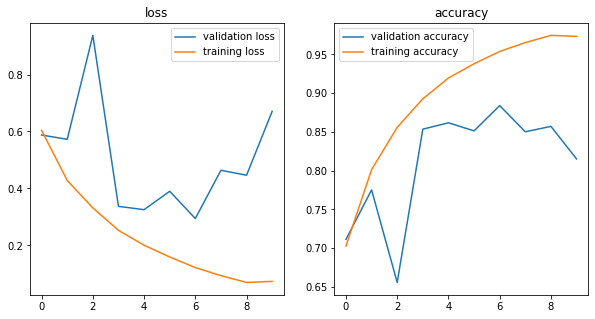

In [30]:
plot_show(cnn_history)

10 에폭으로는 부족한 것처럼 보이긴 함

In [26]:
model2 = Sequential()
model2.add(Conv2D(32, (3,3), input_shape=(IMG_SIZE, IMG_SIZE, 3), activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=2))
model2.add(Dropout(0.2))

model2.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=2))
model2.add(Dropout(0.2))

model2.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=2))
model2.add(Dropout(0.2))

model2.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=2))
model2.add(Dropout(0.2))

model2.add(Flatten())
model2.add(Dense(512, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dense(1, activation='sigmoid'))

model2.compile(loss='binary_crossentropy',
              optimizer='adam',
             metrics=['accuracy'])

model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
batch_normalization_5 (Batch (None, 222, 222, 32)      128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
batch_normalization_6 (Batch (None, 109, 109, 64)      256       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 54, 54, 64)       

In [27]:
callbacks_list = [callbacks.EarlyStopping(monitor='val_loss', 
                                          patience=5,
                                         restore_best_weights=True),
                 callbacks.ReduceLROnPlateau(monitor='val_loss',
                                            patience=3,
                                            factor=0.2,
                                            min_lr=0.0000001)]

In [28]:
cnn_history2 = model2.fit(train_gen,
                       epochs = 50,
                       validation_data = validation_gen,
                       callbacks = callbacks_list)

Epoch 1/50
625/625 [==============================] - 81s 128ms/step - loss: 0.5864 - accuracy: 0.7101 - val_loss: 0.6442 - val_accuracy: 0.6970
Epoch 2/50
625/625 [==============================] - 79s 126ms/step - loss: 0.4073 - accuracy: 0.8146 - val_loss: 0.4596 - val_accuracy: 0.7990
Epoch 3/50
625/625 [==============================] - 79s 127ms/step - loss: 0.3122 - accuracy: 0.8672 - val_loss: 0.5924 - val_accuracy: 0.7542
Epoch 4/50
625/625 [==============================] - 80s 127ms/step - loss: 0.2408 - accuracy: 0.9010 - val_loss: 0.3618 - val_accuracy: 0.8490
Epoch 5/50
625/625 [==============================] - 80s 128ms/step - loss: 0.1859 - accuracy: 0.9256 - val_loss: 0.2837 - val_accuracy: 0.8856
Epoch 6/50
625/625 [==============================] - 79s 127ms/step - loss: 0.1388 - accuracy: 0.9456 - val_loss: 0.4290 - val_accuracy: 0.8316
Epoch 7/50
625/625 [==============================] - 79s 127ms/step - loss: 0.1020 - accuracy: 0.9618 - val_loss: 0.7336 - val_ac

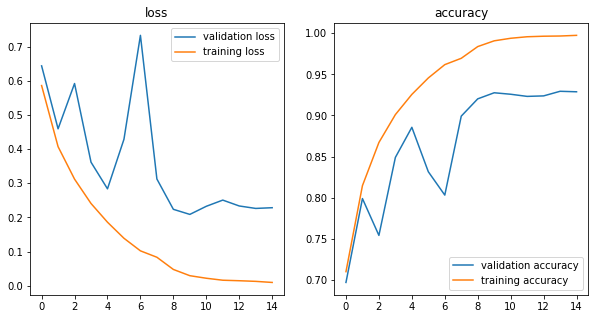

In [31]:
plot_show(cnn_history2)

In [33]:
model3 = Sequential()
model3.add(Conv2D(32, (3,3), input_shape=(IMG_SIZE, IMG_SIZE, 3), activation='relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling2D(pool_size=2))
model3.add(Dropout(0.2))

model3.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling2D(pool_size=2))
model3.add(Dropout(0.2))

model3.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling2D(pool_size=2))
model3.add(Dropout(0.2))

model3.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling2D(pool_size=2))
model3.add(Dropout(0.2))

model3.add(Flatten())
model3.add(Dense(512, activation='relu'))
model3.add(BatchNormalization())
model3.add(Dense(1, activation='sigmoid'))

model3.compile(loss='binary_crossentropy',
              optimizer='Adam',
             metrics=['accuracy'])

model3.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
batch_normalization_10 (Batc (None, 222, 222, 32)      128       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
batch_normalization_11 (Batc (None, 109, 109, 64)      256       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 54, 54, 64)       

In [34]:
cnn_history3 = model3.fit(train_gen,
                       epochs = 50,
                       validation_data = validation_gen,
                       callbacks = callbacks_list)

Epoch 1/50
625/625 [==============================] - 80s 126ms/step - loss: 0.6151 - accuracy: 0.6909 - val_loss: 0.5879 - val_accuracy: 0.6884
Epoch 2/50
625/625 [==============================] - 78s 125ms/step - loss: 0.4513 - accuracy: 0.7890 - val_loss: 0.4726 - val_accuracy: 0.7902
Epoch 3/50
625/625 [==============================] - 78s 125ms/step - loss: 0.3637 - accuracy: 0.8372 - val_loss: 1.6338 - val_accuracy: 0.5676
Epoch 4/50
625/625 [==============================] - 78s 124ms/step - loss: 0.2822 - accuracy: 0.8834 - val_loss: 0.5583 - val_accuracy: 0.7916
Epoch 5/50
625/625 [==============================] - 78s 124ms/step - loss: 0.2124 - accuracy: 0.9148 - val_loss: 0.3278 - val_accuracy: 0.8654
Epoch 6/50
625/625 [==============================] - 80s 128ms/step - loss: 0.2132 - accuracy: 0.9132 - val_loss: 0.3345 - val_accuracy: 0.8496
Epoch 7/50
625/625 [==============================] - 78s 125ms/step - loss: 0.1418 - accuracy: 0.9471 - val_loss: 0.3699 - val_ac

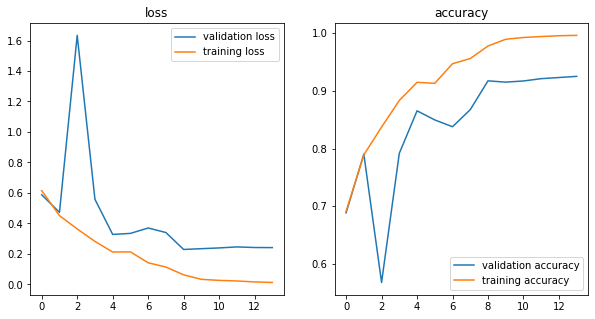

In [35]:
plot_show(cnn_history3)

In [40]:
model.save('/aiffel/aiffel/DLthon/cnn_model1.h5', save_format = 'h5')
model2.save('/aiffel/aiffel/DLthon/cnn_model2.h5', save_format = 'h5')
model3.save('/aiffel/aiffel/DLthon/cnn_model3.h5', save_format = 'h5')

## Xception

In [50]:
optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.0001)

In [53]:
xception = tf.keras.applications.Xception(include_top = False, 
                                          weights = 'imagenet', 
                                          input_shape = (IMG_SIZE, IMG_SIZE, 3))

xception.trainable = False
xception_model = Sequential(
    [xception,
     Flatten(),
     Dense(512, activation = 'relu'),
     Dropout(0.2),
     Dense(1, activation = 'sigmoid')]
    )

xception_model.compile(optimizer = optimizer,
                       loss = 'binary_crossentropy',
                       metrics = ['accuracy'])

xception_model.summary()

83697664/83683744 [==============================] - 0s 0us/step
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 7, 7, 2048)        20861480  
_________________________________________________________________
flatten_6 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_12 (Dense)             (None, 512)               51380736  
_________________________________________________________________
dropout_15 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 513       
Total params: 72,242,729
Trainable params: 51,381,249
Non-trainable params: 20,861,480
_________________________________________________________________


In [57]:
xception_history = xception_model.fit(train_gen,
                                     epochs = 50,
                                     validation_data = validation_gen,
                                     callbacks=callbacks_list)

Epoch 1/50
625/625 [==============================] - 125s 194ms/step - loss: 0.0817 - accuracy: 0.9755 - val_loss: 0.0466 - val_accuracy: 0.9848
Epoch 2/50
625/625 [==============================] - 120s 191ms/step - loss: 0.0419 - accuracy: 0.9859 - val_loss: 0.0415 - val_accuracy: 0.9860
Epoch 3/50
625/625 [==============================] - 120s 192ms/step - loss: 0.0358 - accuracy: 0.9874 - val_loss: 0.0401 - val_accuracy: 0.9866
Epoch 4/50
625/625 [==============================] - 120s 191ms/step - loss: 0.0318 - accuracy: 0.9889 - val_loss: 0.0389 - val_accuracy: 0.9868
Epoch 5/50
625/625 [==============================] - 120s 191ms/step - loss: 0.0297 - accuracy: 0.9895 - val_loss: 0.0382 - val_accuracy: 0.9872
Epoch 6/50
625/625 [==============================] - 119s 191ms/step - loss: 0.0278 - accuracy: 0.9903 - val_loss: 0.0378 - val_accuracy: 0.9870
Epoch 7/50
625/625 [==============================] - 120s 191ms/step - loss: 0.0259 - accuracy: 0.9914 - val_loss: 0.0378 -

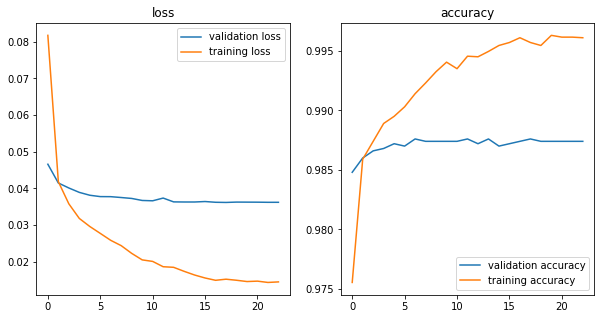

In [58]:
plot_show(xception_history)

에폭을 진행할수록 val_loss와 val_accuracy가 변화가 유의미한 변화를 가져오진 않은 것처럼 보임

In [71]:
xception_model.save('/aiffel/aiffel/DLthon/xception_model.h5', save_format = 'h5', overwrite=True)

/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


## test 데이터셋으로 예측하기

In [76]:
test_df = pd.DataFrame({'filename': test_file_names})

test_data_gen = ImageDataGenerator(rescale = 1./255)

test_gen = test_data_gen.flow_from_dataframe(test_df, TEST_DIR_PATH,
                                             x_col = 'filename',
                                             y_col = None,
                                             class_mode = None,
                                             target_size = (IMG_SIZE, IMG_SIZE),
                                             shuffle = False)

Found 12500 validated image filenames.


In [77]:
df = pd.read_csv("/aiffel/aiffel/DLthon/data/sampleSubmission.csv")
df.head()

id  label
0   1      0
1   2      0
2   3      0
3   4      0
4   5      0

### Vanilla CNN

In [79]:
cnn_pred = model3.predict(test_gen)

In [109]:
df['label'] = cnn_pred
df.head(10)

id         label
0   1  1.205669e-02
1   2  1.804969e-06
2   3  9.994380e-01
3   4  9.981680e-01
4   5  9.550983e-01
5   6  2.307602e-01
6   7  2.124286e-03
7   8  3.141274e-01
8   9  6.426943e-03
9  10  4.027271e-08

In [110]:
# df = df.drop('cnn_pred', axis=1)
df.to_csv('cnn_submission.csv', index=False)

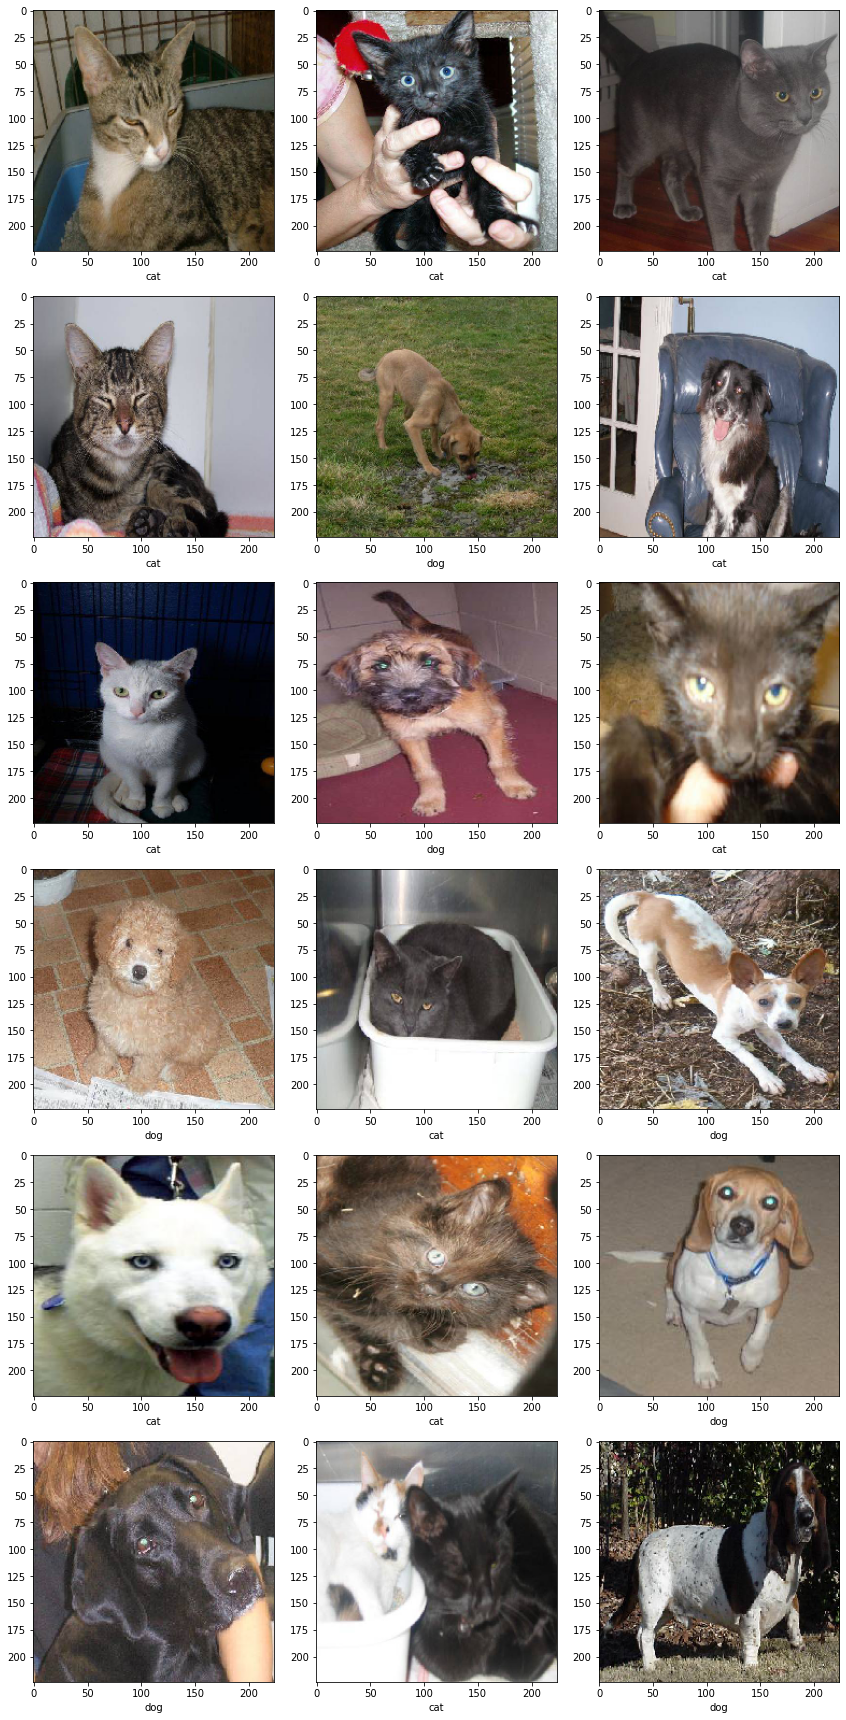

In [95]:
from keras.preprocessing.image import load_img

def pred_show(pred):
    test_df['pred'] = pred
    test_df['category'] = test_df['pred'].apply(lambda x: 'cat' if x < 0.5 else 'dog')
    
    sample_test = test_df.sample(18)
    sample_test.reset_index(drop=True, inplace=True)
    
    plt.figure(figsize=(12, 24))
    for index, row in sample_test.iterrows():
        filename = row['filename']
        category = row['category']
        img = load_img(TEST_DIR_PATH+'/'+filename, target_size=(IMG_SIZE, IMG_SIZE))
        plt.subplot(6, 3, index+1)
        plt.imshow(img)
        plt.xlabel(category)
    plt.tight_layout()
    plt.show()
    
pred_show(cnn_pred)
    

### Xception

In [100]:
xcep_pred = xception_model.predict(test_gen)

In [114]:
xcep_df = df.copy(deep=True)
xcep_df['label'] = xcep_pred
xcep_df.to_csv('xception_submission.csv', index=False)

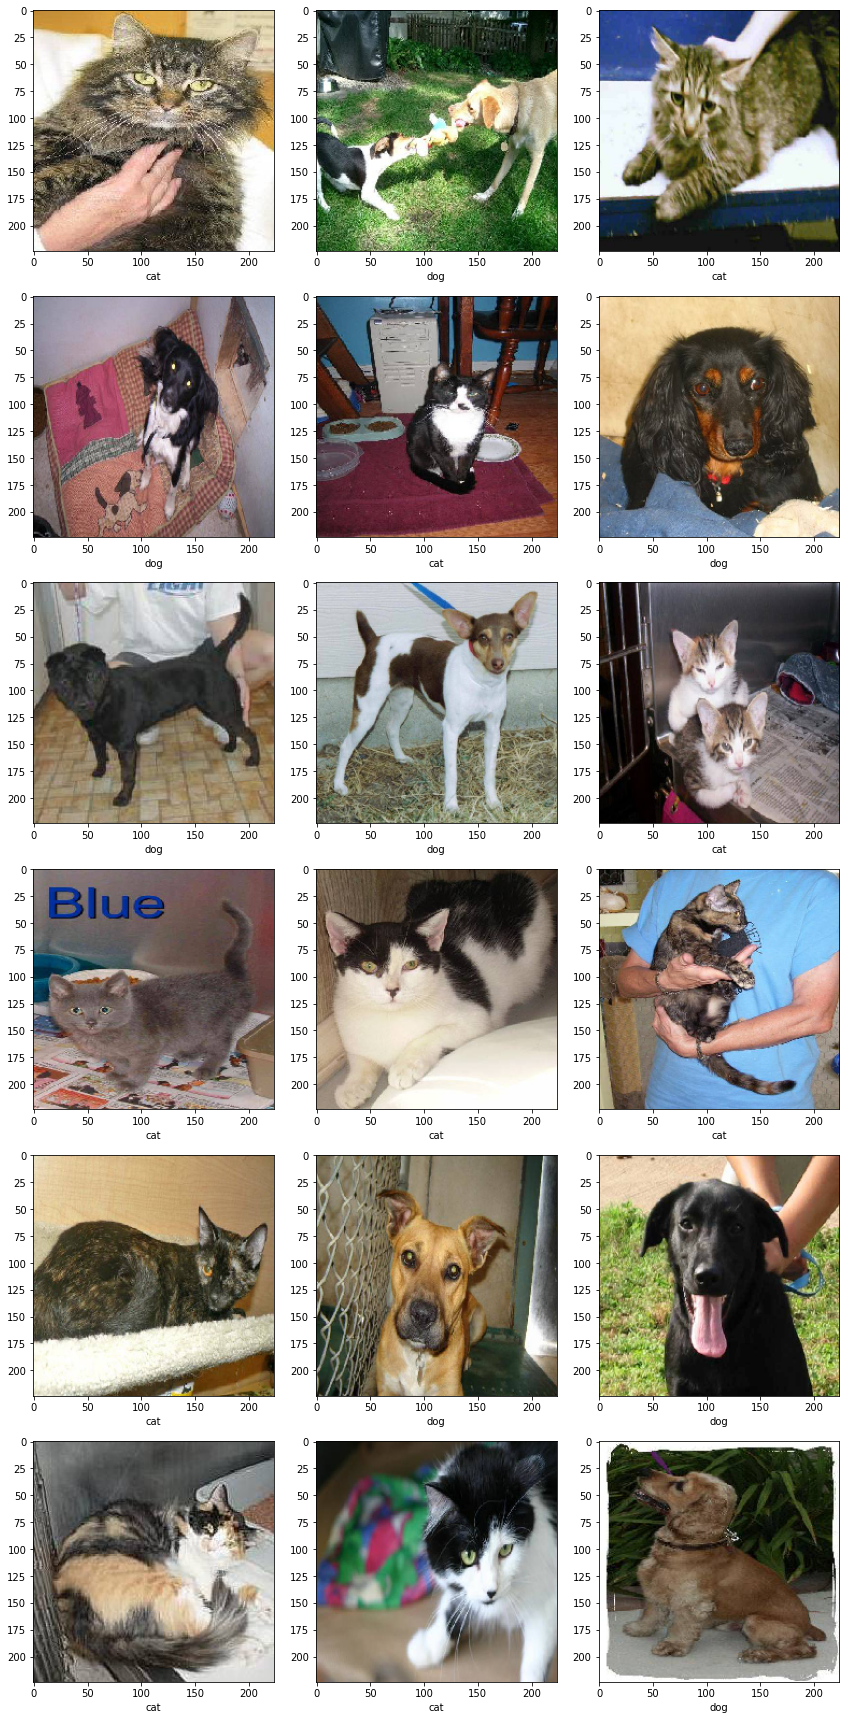

In [102]:
pred_show(xcep_pred)